In [1]:
import sys
sys.path.append("../../")
from mfmodeling import NARGP, SingleGP
from time import time as timer
import pickle

# Uncomment below to use GPy implementation.
# Note that only RBF kernel is supported in the GPy implementation now.
"""
from mfmodeling.SingleGP_GPy import SingleGP
from mfmodeling import set_gpy_usage_in_nargp
set_gpy_usage_in_nargp(True)
"""

help(NARGP)

2024-10-25 15:20:43.581747: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-25 15:20:43.678498: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-25 15:20:43.682122: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/smaeyama/mylib/netcdf-fortran-4.6.1-ifx/lib:/opt/intel/oneapi/tbb/2021.12/env/../lib/intel64/gcc4.8:/

Help on class NARGP in module mfmodeling.NARGP:

class NARGP(builtins.object)
 |  NARGP(*args, **kwargs)
 |  
 |  Nonlinear autoregressive multi-fidelity Gaussian process regression (NARGP).
 |  P. Perdikaris, et al., "Nonlinear information fusion algorithms for data-efficient multi-fidelity modeling"
 |  Proc. R. Soc. A 473, 20160751 (2017). http://dx.doi.org/10.1098/rspa.2016.0751
 |  
 |  Methods defined here:
 |  
 |  __init__(self, *args, **kwargs)
 |      Parameters
 |      ----------
 |      data_list : list[nfidelity]
 |          List of multi-fidelity training data of y=f(x), where input x and output y are vectors.
 |      
 |          Structure of the list of data is as follow.
 |          data_list[ 0] = [data_input_lowest[nsample_lowest,ninput],   data_output_lowest[nsample_lowest,noutput_lowest]]
 |          data_list[ 1] = [data_input_1st[nsample_1st,ninput],         data_output_1st[nsample_1st,noutput_1st]]
 |          ...
 |          data_list[-1] = [data_input_highest[

### Preparation of data set

In [2]:
import numpy as np
import scipy as sp
import tensorflow as tf
from matplotlib import pyplot as plt

np.random.seed(15)
tf.random.set_seed(15)

def high(x):
    '''
    High-fidelity function
    '''
    x1 = x[...,0]
    x2 = x[...,1]
    r = np.sqrt(x1**2+x2**2)
    return sp.special.j0(r)

def low(x):
    '''
    Low-fidelity function
    '''
    x1 = x[...,0]
    x2 = x[...,1]
    r = np.sqrt(x1**2+x2**2)
    return (1-r**2/4)/(1+r**4)+np.sqrt(2/(np.pi*np.abs(r)))*r**4/(1+r**4)

def scale_range(x,ub,lb):
    Np = x.shape[0]
    dim = x.shape[1]
    for i in range(0,Np):
        for j in range(0,dim):
            tmp = ub[j] -lb[j]
            x[i][j] = tmp*x[i][j] + lb[j]
    return x

def rmse(pred, truth):
    pred = pred.flatten()
    truth = truth.flatten()
    return np.sqrt(np.mean((pred-truth)**2))


# nlow = 400
# w0 = -10 + 20*np.random.rand(nlow)
# w1 = -10 + 20*np.random.rand(nlow)
# # w0 = 5*np.random.normal(size=nlow)
# # w1 = 5*np.random.normal(size=nlow)
# data_low_x = np.stack([w0,w1],axis=-1)
from scipy.stats import qmc
pow2=9
sampler = qmc.Sobol(d=2, seed=np.random.default_rng(15))
data_low_x = np.array((-8,-8)) + sampler.random_base2(m=pow2)*np.array((16,16))
nlow=2**pow2
data_low_y = low(data_low_x)
print(data_low_x.shape)

data_restrict = data_low_x[data_low_x[:,0]<1e-8]
data_restrict = data_restrict[-5<data_restrict[:,0]]
data_restrict = data_restrict[data_restrict[:,1]<5]
data_restrict = data_restrict[-5<data_restrict[:,1]]
print(data_restrict.shape)
nhigh = data_restrict.shape[0]
if data_restrict.shape[0] < nhigh:
    print("Data points in the restricted region is too small")
else:
    perm = np.random.permutation(data_restrict.shape[0])
    data_high_x = data_restrict[perm[0:nhigh],:]
print(data_high_x.shape)

(512, 2)
(100, 2)
(100, 2)


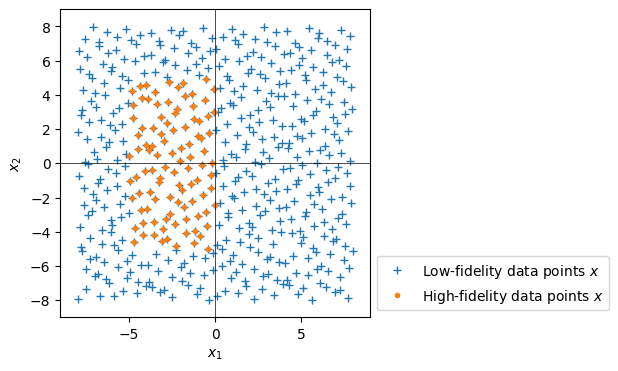

In [3]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()
ax.plot(data_low_x[:,0],data_low_x[:,1],"+",label=r"Low-fidelity data points $x$")
ax.plot(data_high_x[:,0],data_high_x[:,1],".",label=r"High-fidelity data points $x$")
ax.axhline(0,lw=0.5,c="k")
ax.axvline(0,lw=0.5,c="k")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_xlim(-9,9)
ax.set_ylim(-9,9)
ax.legend(loc="lower left", bbox_to_anchor=(1,0))
plt.show()

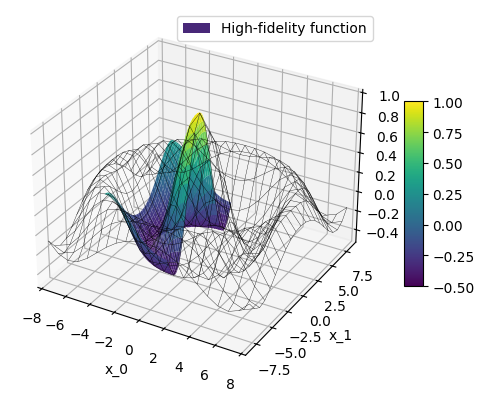

In [4]:
# 推定に用いる入力データ: Low, medium, high-fidelity dataset
data_low_y = low(data_low_x)
data_high_y = high(data_high_x)

# データセットの描画
%matplotlib inline
# %matplotlib qt
x0_data = np.linspace(-5,0,101)
x1_data = np.linspace(-5,5,101)
x0m_data, x1m_data = np.meshgrid(x0_data,x1_data)
xm_data = np.stack([x0m_data,x1m_data],axis=-1)
x0_mesh = np.linspace(-8,8,21)
x1_mesh = np.linspace(-8,8,21)
x0m_mesh, x1m_mesh = np.meshgrid(x0_mesh,x1_mesh)
xm_mesh = np.stack([x0m_mesh,x1m_mesh],axis=-1)

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_wireframe(x0m_mesh,x1m_mesh,high(xm_mesh),lw=0.25,color="black")
# surf = ax.plot_surface(x0m,x1m,high(xm),cmap="viridis",label="High-fidelity function")
surf = ax.plot_surface(x0m_data,x1m_data,high(xm_data),cmap="viridis",vmax=1,vmin=-0.5,label="High-fidelity function")
ax.set_xlim(-8,8)
fig.colorbar(surf, shrink=0.5, aspect=10)
# ax.plot(data_high_x[:,0],data_high_x[:,1],data_high_y,"*",label="Input data for GP")
ax.set_xlabel(r"x_0")
ax.set_ylabel(r"x_1")
ax.set_zlim(-0.5,1)
ax.view_init(30,-60)
ax.legend()
plt.show()


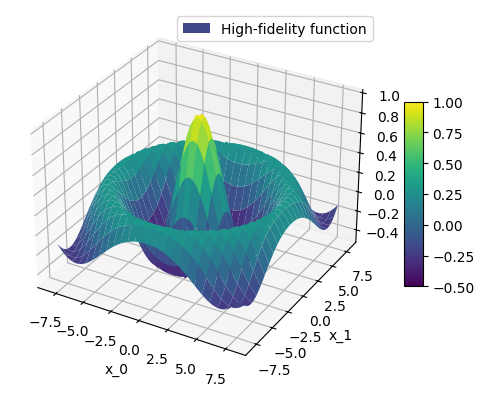

/tmp/ipykernel_60419/1551207023.py:25: RuntimeWarning: divide by zero encountered in divide
  return (1-r**2/4)/(1+r**4)+np.sqrt(2/(np.pi*np.abs(r)))*r**4/(1+r**4)
/tmp/ipykernel_60419/1551207023.py:25: RuntimeWarning: invalid value encountered in multiply
  return (1-r**2/4)/(1+r**4)+np.sqrt(2/(np.pi*np.abs(r)))*r**4/(1+r**4)


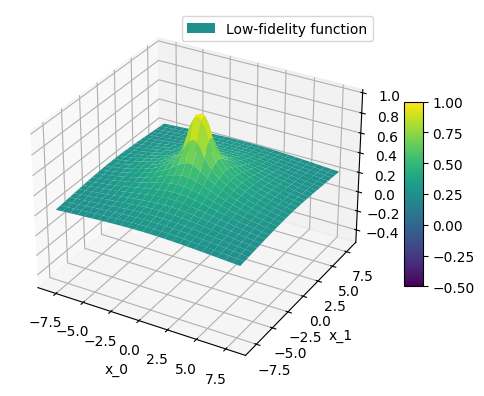

In [5]:
# 推定に用いる入力データ: Low, medium, high-fidelity dataset
data_low_y = low(data_low_x)
data_high_y = high(data_high_x)

# データセットの描画
%matplotlib inline
# %matplotlib qt
x0 = np.linspace(-8,8,51)
x1 = np.linspace(-8,8,51)
x0m, x1m = np.meshgrid(x0,x1)
xm = np.stack([x0m,x1m],axis=-1)

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
# ax.plot_wireframe(x0m,x1m,high(xm),lw=0.5,color="black",label="High-fidelity function")
surf = ax.plot_surface(x0m,x1m,high(xm),cmap="viridis",vmax=1,vmin=-0.5,label="High-fidelity function")
# surf = ax.plot_surface(x0m[:,:50],x1m[:,:50],high(xm)[:,:50],cmap="viridis",label="High-fidelity function")
# ax.set_xlim(-8,8)
fig.colorbar(surf, shrink=0.5, aspect=10)
# ax.plot(data_high_x[:,0],data_high_x[:,1],data_high_y,"*",label="Input data for GP")
ax.set_xlabel(r"x_0")
ax.set_ylabel(r"x_1")
ax.set_zlim(-0.5,1)
ax.view_init(30,-60)
ax.legend()
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
# ax.plot_wireframe(x0m,x1m,low(xm),lw=0.5,color="black",label="Low-fidelity function")
surf = ax.plot_surface(x0m,x1m,low(xm),cmap="viridis",vmax=1,vmin=-0.5,label="Low-fidelity function")
fig.colorbar(surf, shrink=0.5, aspect=10)
# ax.plot(data_low_x[:,0],data_low_x[:,1],data_low_y,"*",label="Input data for GP")
ax.set_xlabel(r"x_0")
ax.set_ylabel(r"x_1")
ax.set_zlim(-0.5,1)
ax.view_init(30,-60)
ax.legend()
plt.show()

### Nonlinear autoregressive multi-fidelity Gaussian process regression (NARGP)

In [6]:
# Set kernel name to use
# KERNEL_NAME = "RBF"
# KERNEL_NAME = "SpectralMixture"
KERNEL_NAME = "NeuralKernelNetwork"

data_list = [[data_low_x,data_low_y[:,None]],
             [data_high_x,data_high_y[:,None]]]
single_gp_config_list = [
    {"kernel": KERNEL_NAME},
    {"kernel": KERNEL_NAME},
]

# Uncomment the following to use different kernel for different fidelity data.
# However, if GPy implementation are being used,
# Spectral Mixture Kernel and Neural Kernel Network are not implemented,
# so RBF will be used.

# Different kernel for each fidelity
#single_gp_config_list = [
#    {"kernel": "RBF"},
#    {"kernel": "SpectralMixture"},
#    {"kernel": "NeuralKernelNetwork"},
#]

# Different initialization for each fidelity
#single_gp_config_list = [
#    {"kernel": "RBF", "kernel_args": {"lengthscales": [1.0, 1.0]}},
#    {"kernel": "RBF", "kernel_args": {"lengthscales": [2.0, 2.0]}},
#    {"kernel": "RBF", "kernel_args": {"lengthscales": [3.0, 3.0]}},
#]

# model_nargp = NARGP(
#     data_list = data_list,
#     single_gp_config_list=single_gp_config_list,
#     normalize=True)
# t1=timer()
# model_nargp.optimize(optimize_restarts=10, nMonteCarlo=1000, verbose=False)
# t2=timer(); print(t2-t1, xm.size)


# if KERNEL_NAME == "RBF":
#     with open("model_NARGP_RBF.pkl","wb") as f:
#         pickle.dump(model_nargp,f)
# elif KERNEL_NAME == "SpectralMixture":
#     with open("model_NARGP_SMK.pkl","wb") as f:
#         pickle.dump(model_nargp,f)
# elif KERNEL_NAME == "NeuralKernelNetwork":
#     with open("model_NARGP_NKN.pkl","wb") as f:
#         pickle.dump(model_nargp,f)


if KERNEL_NAME == "RBF":
    with open("model_NARGP_RBF.pkl","rb") as f:
        model_nargp = pickle.load(f)
elif KERNEL_NAME == "SpectralMixture":
    with open("model_NARGP_SMK.pkl","rb") as f:
        model_nargp = pickle.load(f)
elif KERNEL_NAME == "NeuralKernelNetwork":
    with open("model_NARGP_NKN.pkl","rb") as f:
        model_nargp = pickle.load(f)



t1=timer()
mean, var = model_nargp.predict(xm.reshape(xm.size//2,2),nMonteCarlo=100)
t2=timer(); print(t2-t1, xm.size)

2024-10-25 15:20:46.578154: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/smaeyama/mylib/netcdf-fortran-4.6.1-ifx/lib:/opt/intel/oneapi/tbb/2021.12/env/../lib/intel64/gcc4.8:/opt/intel/oneapi/mpi/2021.12/opt/mpi/libfabric/lib:/opt/intel/oneapi/mpi/2021.12/lib:/opt/intel/oneapi/mkl/2024.1/lib:/opt/intel/oneapi/ippcp/2021.11/lib/:/opt/intel/oneapi/ipp/2021.11/lib:/opt/intel/oneapi/dpl/2022.5/lib:/opt/intel/oneapi/dnnl/2024.1/lib:/opt/intel/oneapi/debugger/2024.1/opt/debugger/lib:/opt/intel/oneapi/dal/2024.2/lib:/opt/intel/oneapi/compiler/2024.1/opt/oclfpga/host/linux64/lib:/opt/intel/oneapi/compiler/2024.1/opt/compiler/lib:/opt/intel/oneapi/compiler/2024.1/lib:/opt/intel/oneapi/ccl/2021.12/lib/
2024-10-25 15:20:46.578203: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
202

8.101304531097412 5202


### Single GP using only high-fidelity data (for comparison)

In [7]:
data = [data_high_x,data_high_y[:,None]]
# model_singlegp = SingleGP(data = data, kernel=KERNEL_NAME, normalize=True)
# model_singlegp.optimize(optimize_restarts=10, verbose=False)


# if KERNEL_NAME == "RBF":
#     with open("model_singleGP_RBF.pkl","wb") as f:
#         pickle.dump(model_singlegp,f)
# elif KERNEL_NAME == "SpectralMixture":
#     with open("model_singleGP_SMK.pkl","wb") as f:
#         pickle.dump(model_singlegp,f)
# elif KERNEL_NAME == "NeuralKernelNetwork":
#     with open("model_singleGP_NKN.pkl","wb") as f:
#         pickle.dump(model_singlegp,f)


if KERNEL_NAME == "RBF":
    with open("model_singleGP_RBF.pkl","rb") as f:
        model_singlegp = pickle.load(f)
elif KERNEL_NAME == "SpectralMixture":
    with open("model_singleGP_SMK.pkl","rb") as f:
        model_singlegp = pickle.load(f)
elif KERNEL_NAME == "NeuralKernelNetwork":
    with open("model_singleGP_NKN.pkl","rb") as f:
        model_singlegp = pickle.load(f)


mean_singlegp, var_singlegp = model_singlegp.predict(xm.reshape(xm.size//2,2))

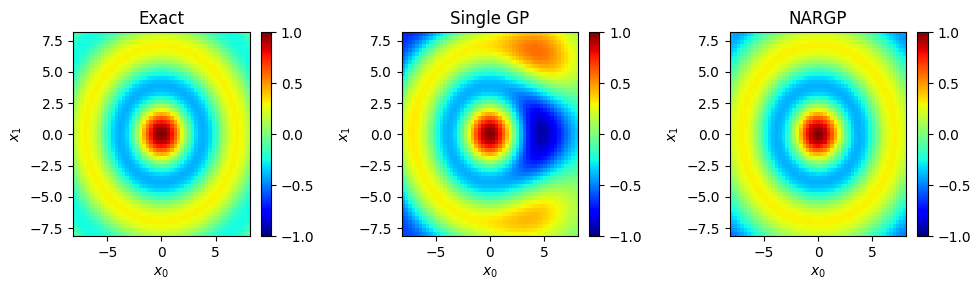

In [8]:
vmax = high(xm).max()
vmin = high(xm).min()
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(131)
quad = ax.pcolormesh(x0m,x1m,high(xm),cmap="jet",vmax=vmax,vmin=-vmax)
ax.set_title("Exact")
ax.set_xlabel(r"$x_0$")
ax.set_ylabel(r"$x_1$")
fig.colorbar(quad)
ax = fig.add_subplot(132)
quad = ax.pcolormesh(x0m,x1m,mean_singlegp.reshape(x0m.shape),cmap="jet",vmax=vmax,vmin=-vmax)
ax.set_title("Single GP")
ax.set_xlabel(r"$x_0$")
ax.set_ylabel(r"$x_1$")
fig.colorbar(quad)
ax = fig.add_subplot(133)
quad = ax.pcolormesh(x0m,x1m,mean.reshape(x0m.shape),cmap="jet",vmax=vmax,vmin=-vmax)
ax.set_title("NARGP")
ax.set_xlabel(r"$x_0$")
ax.set_ylabel(r"$x_1$")
fig.colorbar(quad)
fig.tight_layout()
plt.show()

0.6167756006802924 0.9384998925578237 0.09268706371022947 0.40217755363236085 0.9384998925578237


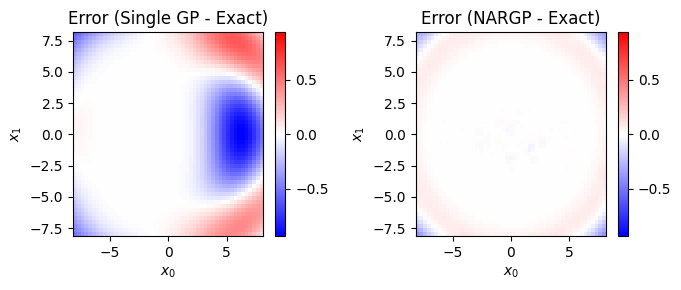

In [9]:
error_singlegp = mean_singlegp.reshape(x0m.shape)-high(xm)
error_nargp = mean.reshape(x0m.shape)-high(xm)
emax = max([error_singlegp.max(),-error_singlegp.min(),error_nargp.max(),-error_nargp.min()])
print(error_singlegp.max(),-error_singlegp.min(),error_nargp.max(),-error_nargp.min(),emax)

fig = plt.figure(figsize=(7,3))
ax = fig.add_subplot(121)
quad = ax.pcolormesh(x0m,x1m,error_singlegp,vmax=emax,vmin=-emax,cmap="bwr")
ax.set_title("Error (Single GP - Exact)")
ax.set_xlabel(r"$x_0$")
ax.set_ylabel(r"$x_1$")
fig.colorbar(quad)
ax = fig.add_subplot(122)
quad = ax.pcolormesh(x0m,x1m,error_nargp,vmax=emax,vmin=-emax,cmap="bwr")
ax.set_title("Error (NARGP - Exact)")
ax.set_xlabel(r"$x_0$")
ax.set_ylabel(r"$x_1$")
fig.colorbar(quad)
fig.tight_layout()
plt.show()

In [10]:
nsample = 1000
w0 = -8 + 16*np.random.rand(nsample)
w1 = -8 + 16*np.random.rand(nsample)
xsample = np.stack([w0,w1],axis=-1)

t1=timer()
mean0, var0 = model_nargp.predict(xsample,ifidelity=0,nMonteCarlo=100)
t2=timer(); print(t2-t1, xsample.size); t1 = timer()
mean1, var1 = model_nargp.predict(xsample,ifidelity=1,nMonteCarlo=100)
t2=timer(); print(t2-t1, xsample.size); t1 = timer()

0.5048398971557617 2000
3.153991460800171 2000


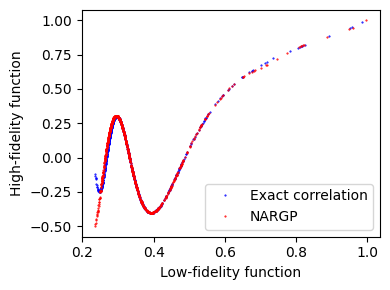

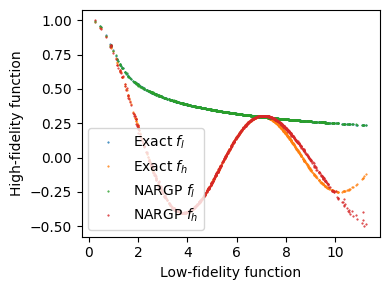

In [11]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
ax.plot(low(xsample),high(xsample),"b.",markersize=1,label="Exact correlation")
ax.plot(mean0,mean1,"r.",markersize=1,label="NARGP")
ax.set_xlabel("Low-fidelity function")
ax.set_ylabel("High-fidelity function")
ax.legend()
fig.tight_layout()
ax.legend()
plt.show()

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
ax.plot(np.sqrt((xsample**2).sum(axis=-1)),low(xsample),".",markersize=1,label="Exact $f_l$")
ax.plot(np.sqrt((xsample**2).sum(axis=-1)),high(xsample),".",markersize=1,label="Exact $f_h$")
ax.plot(np.sqrt((xsample**2).sum(axis=-1)),mean0,".",markersize=1,label="NARGP $f_l$")
ax.plot(np.sqrt((xsample**2).sum(axis=-1)),mean1,".",markersize=1,label="NARGP $f_h$")
# ax.plot(mean0,mean1,".",markersize=1,label="NARGP")
ax.set_xlabel("Low-fidelity function")
ax.set_ylabel("High-fidelity function")
ax.legend()
fig.tight_layout()
ax.legend()
plt.show()

(1000, 1) (1000, 1)


/tmp/ipykernel_60419/1332900371.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  R2_singlegp = float(1.0 - sum((exact_high-mean_singlegp)**2)/sum((exact_high-exact_high.mean())**2))
/tmp/ipykernel_60419/1332900371.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  R2_nargp = float(1.0 - sum((exact_high-mean1)**2)/sum((exact_high-exact_high.mean())**2))


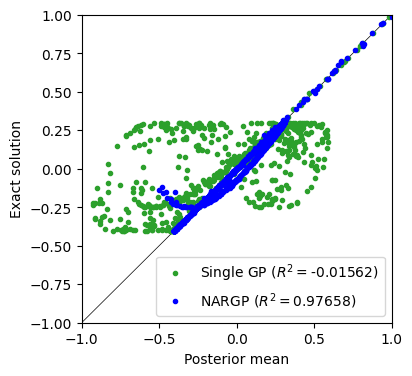

In [12]:
mean_singlegp, var_singlegp = model_singlegp.predict(xsample)
exact_high = high(xsample)[:,None]
print(exact_high.shape,mean_singlegp.shape)
R2_singlegp = float(1.0 - sum((exact_high-mean_singlegp)**2)/sum((exact_high-exact_high.mean())**2))
R2_nargp = float(1.0 - sum((exact_high-mean1)**2)/sum((exact_high-exact_high.mean())**2))

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()
vmin = -1
vmax = 1
ax.plot(np.linspace(vmin,vmax,2),np.linspace(vmin,vmax,2),c="k",lw=0.5)
ax.plot(mean_singlegp,exact_high,".",c="tab:green",label="Single GP ($R^2=${:.5f})".format(R2_singlegp))
ax.plot(mean1,exact_high,".",c="b",label="NARGP ($R^2=${:.5f})".format(R2_nargp))
ax.set_xlabel("Posterior mean")
ax.set_ylabel("Exact solution")
ax.set_xlim(vmin,vmax)
ax.set_ylim(vmin,vmax)
ax.legend()
plt.show()
